# UN Data

### Setup

In [178]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np

In [124]:
%matplotlib inline

In [3]:
url = "http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm"
r = requests.get(url)

### Use BeautifulSoup to parse out the table and put in sqlite db

In [150]:
soup = BeautifulSoup(r.content)
headers = []
data = []
table = soup('table')[6].find_all('table')[1].find_all('table')[0].find_all('tr')[4:]
for row in table:
    cols = row.find_all('td')
    cols = [x.text.strip() for x in cols]
    data.append([x for x in cols if x and ord(str(x[0])) not in range(97,106)])

In [79]:
head_row = soup.find_all('tr', attrs = {'class': 'lheader'})[0]
head_row = [x.text.strip() for x in head_row.find_all('td') if x.text.strip()]
head_row

[u'Country or area', u'Year', u'Total', u'Men', u'Women']

In [80]:
import sqlite3 as lite

In [103]:
con = lite.connect('un.db')
cur = con.cursor()

In [151]:
cur.execute('DROP TABLE un_education')

In [152]:
cur.execute('CREATE TABLE un_education (country TEXT, year INT, total INT, men INT, women INT)')

In [153]:
with con:
    for row in data:
        cur.execute('INSERT INTO un_education (country, year, total, men, women) VALUES (?,?,?,?,?)',
                        (row[0], row[1], row[2], row[3], row[4],))

### Can then get the data from the db

In [155]:
ed = pd.read_sql_query('SELECT * from un_education ORDER BY country',con,index_col = 'country')

In [156]:
ed.head()

,year,total,men,women
country,,,,
Afghanistan,2004,8,11,5
Albania,2004,11,11,11
Algeria,2005,13,13,13
Andorra,2008,11,11,12
Anguilla,2008,11,11,11


In [218]:
ed.mean()

year     2006.672131
total      12.448087
men        12.393443
women      12.513661
dtype: float64

In [169]:
ed.median()

year     2008.0
total      13.0
men        12.0
women      13.0
dtype: float64

### Seems like women education periods are more distributed

[<matplotlib.text.Text at 0x1265d10d0>, <matplotlib.text.Text at 0x12667d110>]

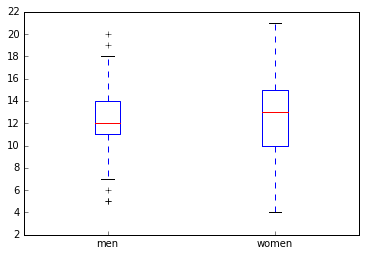

In [185]:
fig = plt.figure()
plt.boxplot([ed.men,ed.women])
ax = fig.add_subplot(111)
ax.get_yaxis().tick_left()
ax.get_xaxis().tick_bottom()
plt.yticks(np.arange(2, 24, 2))
ax.set_xticklabels(['men', 'women'])

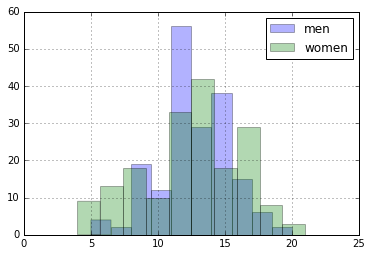

In [168]:
ed.men.hist(alpha = 0.3, label = 'men')
ed.women.hist(alpha = 0.3, label = 'women')
plt.legend()

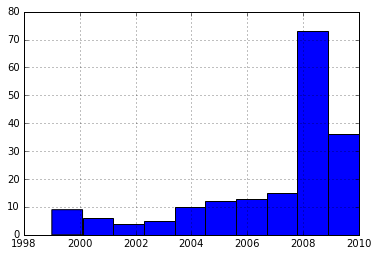

In [186]:
ed.year.hist()

In [ ]:
con.close()

### We can take GDP data using pandas and send it directly to a sqlite db

In [193]:
gdp = pd.read_csv('world_bank_data/GDP.csv', skiprows=3, )
gdp.columns

Index([u'Country Name', u'Country Code', u'Indicator Name', u'Indicator Code',
       u'1960', u'1961', u'1962', u'1963', u'1964', u'1965', u'1966', u'1967',
       u'1968', u'1969', u'1970', u'1971', u'1972', u'1973', u'1974', u'1975',
       u'1976', u'1977', u'1978', u'1979', u'1980', u'1981', u'1982', u'1983',
       u'1984', u'1985', u'1986', u'1987', u'1988', u'1989', u'1990', u'1991',
       u'1992', u'1993', u'1994', u'1995', u'1996', u'1997', u'1998', u'1999',
       u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007',
       u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015',
       u'Unnamed: 60'],
      dtype='object')

In [210]:
gdp[['Country Name','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']].to_sql('gdp',
                    con, index = False)

/Users/danielstallworth/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:1160: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


### Join the education and gdp tables together in sql, then put them in a dataframe

In [338]:
gdp = pd.read_sql_query('SELECT * FROM gdp join un_education as un ' 
                          'on un.country like "%" || gdp."Country Name" || "%" '
                          'or gdp."Country Name" like "%" || un.country || "%"',
                      con, index_col = 'country')

In [339]:
gdp.head()

,Country Name,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,year,total,men,women
country,,,,,,,,,,,,,,,,,
Aruba,Aruba,1.722799e+09,1.873453e+09,1.920263e+09,1.941095e+09,2.021302e+09,2.228279e+09,2.331006e+09,2.421475e+09,2.623726e+09,2.791961e+09,2.498933e+09,2.467704e+09,2009,13,13,13
Andorra,Andorra,1.239840e+09,1.401694e+09,1.484005e+09,1.717564e+09,2.373836e+09,2.916913e+09,3.248135e+09,3.536452e+09,4.010785e+09,4.001349e+09,3.649863e+09,3.346317e+09,2008,11,11,12
Afghanistan,Afghanistan,NaN,NaN,2.461666e+09,4.128818e+09,4.583649e+09,5.285462e+09,6.275076e+09,7.057598e+09,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,2004,8,11,5
Albania,Albania,3.414761e+09,3.632044e+09,4.060759e+09,4.435079e+09,5.746946e+09,7.314865e+09,8.158549e+09,8.992642e+09,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,2004,11,11,11
United Arab Emirates,United Arab Emirates,8.444547e+10,1.043374e+11,1.033116e+11,1.098162e+11,1.243464e+11,1.478244e+11,1.806170e+11,2.221059e+11,2.579161e+11,3.154746e+11,2.535474e+11,2.860493e+11,2003,11,11,12


### Take smallest and largest GDP countries for 2010 (This would mean more if it was gdp per capita)

In [328]:
s = gdp.nsmallest(10,'2010')
d = gdp.nlargest(10,'2010')

In [329]:
from pandas.tools.plotting import scatter_matrix

### Have to melt them to easily look at GDP across countries and education periods rather than years

In [340]:
gdp_melt = pd.melt(gdp, id_vars = ['Country Name','year','total','men','women'], var_name = 'gdp_year', value_name = 'gdp')

In [334]:
dgdp_melt = pd.melt(d, id_vars = ['Country Name','year','total','men','women'], var_name = 'gdp_year', value_name = 'gdp')

In [336]:
sgdp_melt = pd.melt(s, id_vars = ['Country Name','year','total','men','women'], var_name = 'gdp_year', value_name = 'gdp')

### Take the log of gdp to better normalize

In [345]:
dgdp_melt.gdp = dgdp_melt.gdp.apply(lambda x: np.log(x))
sgdp_melt.gdp = sgdp_melt.gdp.apply(lambda x: np.log(x))
gdp_melt.gdp = gdp_melt.gdp.apply(lambda x: np.log(x))

### Scatter Matrix for top countries

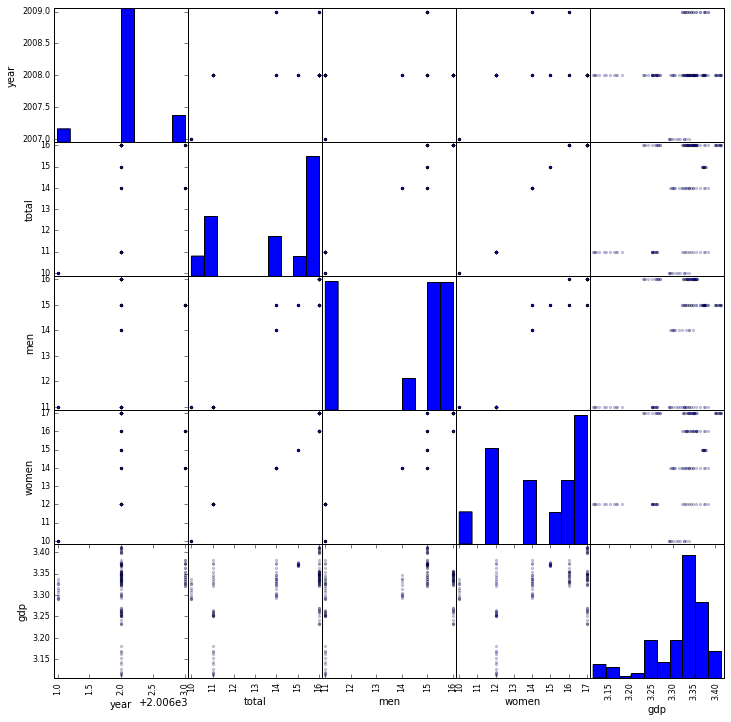

In [346]:
scatter_matrix(dgdp_melt, alpha=0.2, figsize=(12, 12), diagonal='hist');

### Scatter Matrix for low gdp countries

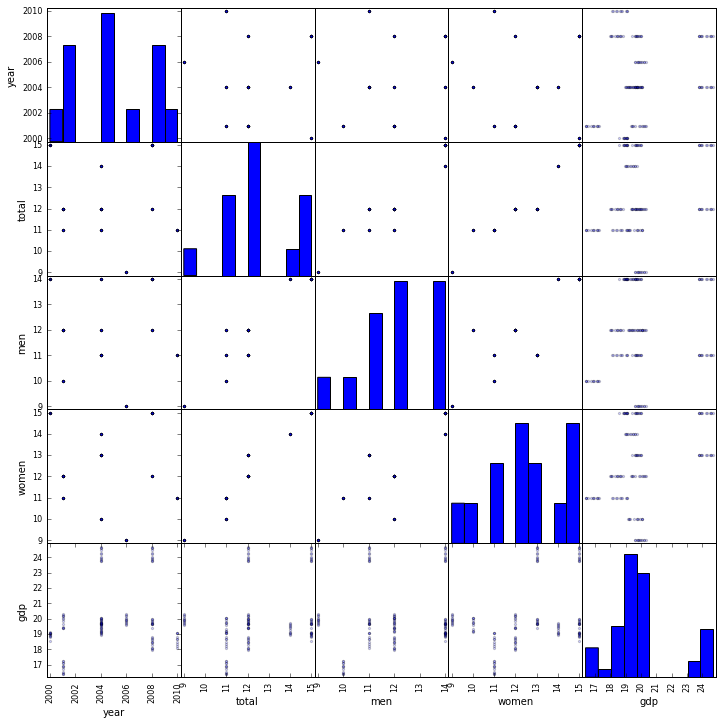

In [347]:
scatter_matrix(sgdp_melt, alpha=0.2, figsize=(12, 12), diagonal='hist');

### Scatter Matrix for all countries, a little bit of a trend upward in gdp as education period increases

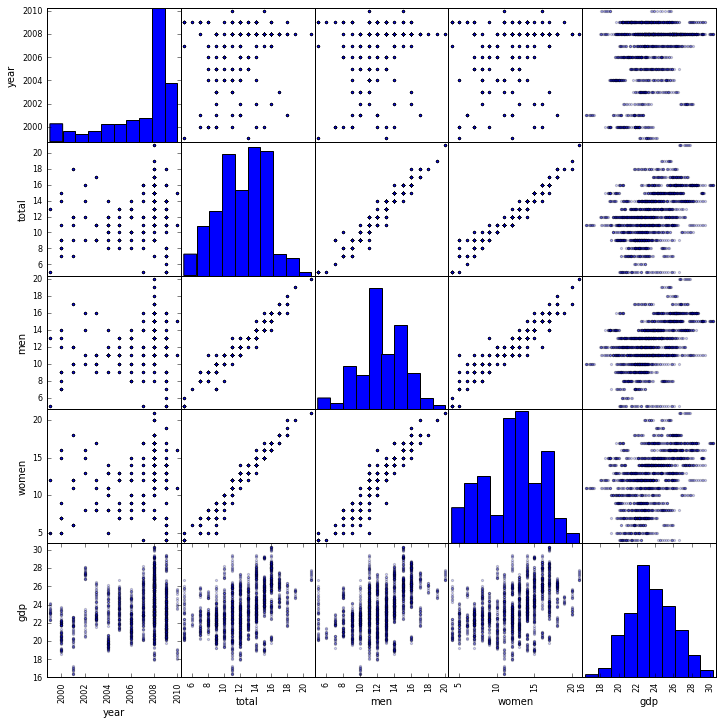

In [348]:
scatter_matrix(gdp_melt, alpha=0.2, figsize=(12, 12), diagonal='hist');

In [355]:
from matplotlib.font_manager import FontProperties

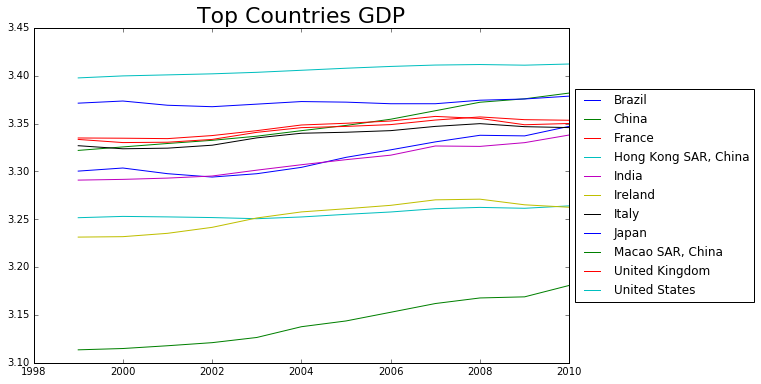

In [404]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
fontP = FontProperties()
fontP.set_size('medium')
#country_grpd = gdp_melt.groupby('Country Name')
for key, grp in dgdp_melt.groupby('Country Name'):
    plt.plot(grp.gdp_year, grp.gdp, label=key)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top Countries GDP", fontsize = 22)
plt.show()

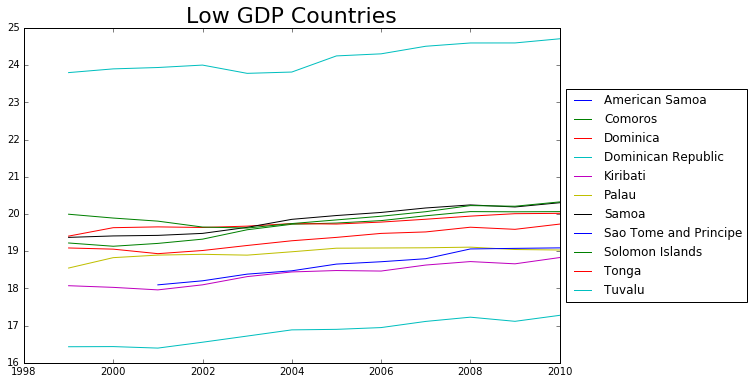

In [405]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
fontP = FontProperties()
fontP.set_size('medium')
for key, grp in sgdp_melt.groupby('Country Name'):
    plt.plot(grp.gdp_year, grp.gdp, label=key)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Low GDP Countries", fontsize = 22)
plt.show()